In [1]:
pip install pandas numpy scikit-learn xgboost pytorch-tabnet torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install qiskit[all]

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install -U qiskit qiskit-machine-learning qiskit-aer

  Using cached qiskit-2.1.1-cp39-abi3-win_amd64.whl.metadata (13 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install qiskit_algorithms

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Quantum + Classical ML Pipeline for Egyptian Archaeological Site Dataset

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Quantum ML imports
from qiskit_aer import Aer
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import SPSA
from qiskit.primitives import Estimator

# Torch for QNN + Huber model
import torch
import torch.nn as nn
import torch.optim as optim

# XGBoost
from xgboost import XGBRegressor

# TabNet
from pytorch_tabnet.tab_model import TabNetRegressor

In [11]:
# 2. Load Data
df = pd.read_csv("C:/Quatum/Dataset_Arqueologico_Egipto_Expandido.csv")
df.dropna(inplace=True)  # Clean NA

In [12]:
# 🧼 2. Load and Prepare Data
df = pd.read_csv('C:/Quatum/Dataset_Arqueologico_Egipto_Expandido.csv')

# Encode categorical columns
label_encoders = {}
for col in ['Time Period', 'Material Composition', 'Script Detected']:
    if col in df.columns:
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Target for regression
y = df['AI Prediction Score']

# Features
features = ['Latitude', 'Longitude', 'Human Activity Index', 'Climate Change Impact', 'Sonar Radar Detection', 'Looting Risk (%)'] + [f'{col}_encoded' for col in label_encoders]
X = df[features]

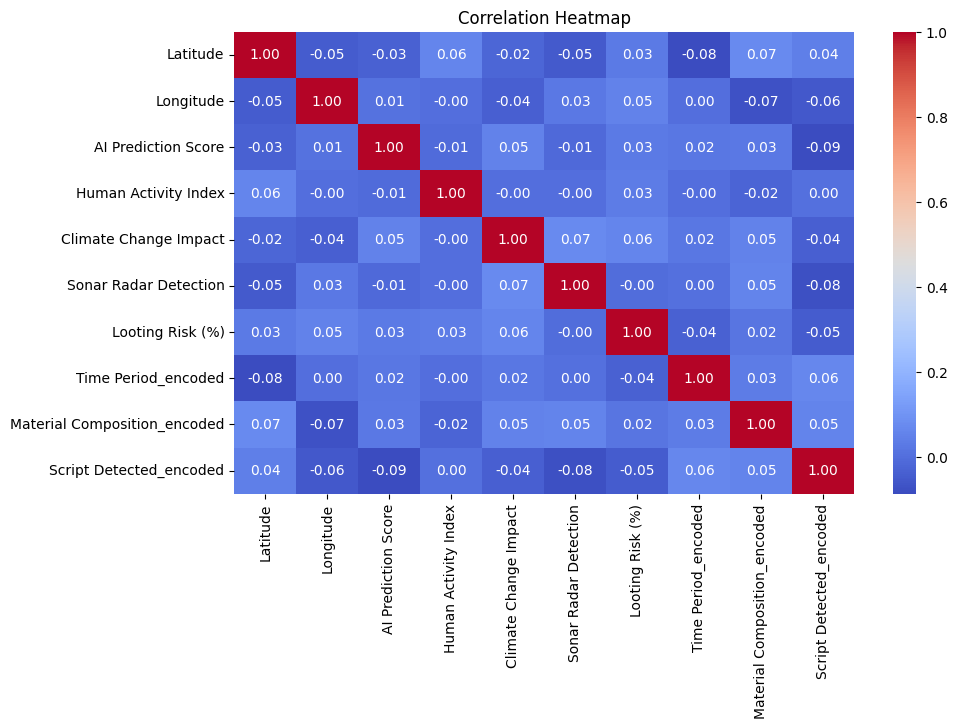

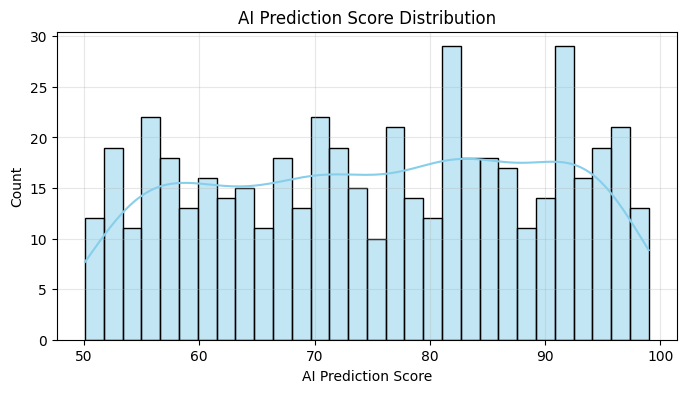

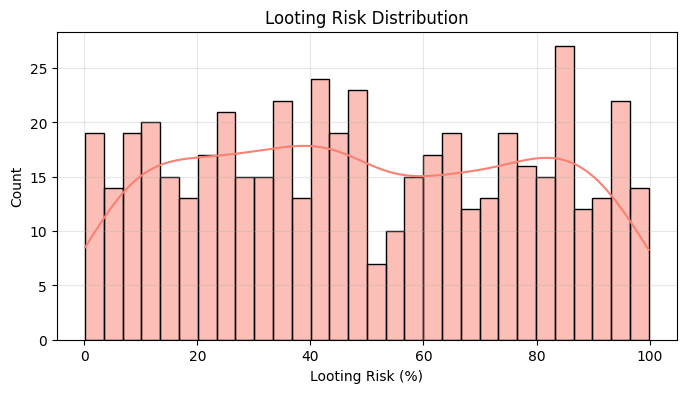

In [13]:
# 🔍 EDA
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df['AI Prediction Score'], bins=30, kde=True, color='skyblue')
plt.title('AI Prediction Score Distribution')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df['Looting Risk (%)'], bins=30, kde=True, color='salmon')
plt.title('Looting Risk Distribution')
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# 🧪 3. Train-Test Split and Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
from pytorch_tabnet.tab_model import TabNetRegressor

# TabNet needs NumPy arrays
X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

tabnet = TabNetRegressor(verbose=0)
tabnet.fit(
    X_train_np,
    y_train.values.reshape(-1, 1),
    max_epochs=100,
    patience=10
)
tabnet_preds = tabnet.predict(X_test_np).ravel()

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [16]:
# 4. Classical Models

## Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

## XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

## TabNet
tabnet = TabNetRegressor(verbose=0)
tabnet.fit(X_train_np, y_train.values.reshape(-1,1), max_epochs=100, patience=10)
tabnet_preds = tabnet.predict(X_test_np).ravel()

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [17]:
# 5. PyTorch Huber Model
class HuberNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

h_model = HuberNet(X_train_np.shape[1])
criterion = nn.HuberLoss()
optimizer = optim.Adam(h_model.parameters(), lr=0.01)

X_train_t = torch.tensor(X_train_np, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32)

for epoch in range(300):
    optimizer.zero_grad()
    outputs = h_model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

h_model.eval()
h_preds = h_model(torch.tensor(X_test_np, dtype=torch.float32)).detach().numpy().ravel()

In [18]:
# 6. Quantum Neural Network (QNN)
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 42

# Create quantum circuit by combining feature_map and ansatz
feature_map = ZZFeatureMap(feature_dimension=X_train_np.shape[1], reps=1)
ansatz = RealAmplitudes(num_qubits=X_train_np.shape[1], reps=1)
qc = feature_map.compose(ansatz)

# Create estimator and QNN
estimator = Estimator()
qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, estimator=estimator)

C:\Users\PC\AppData\Local\Temp\ipykernel_11704\1633197810.py:11: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\PC\AppData\Local\Temp\ipykernel_11704\1633197810.py:12: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, estimator=estimator)


In [19]:
# Convert to Torch model
torch_qnn = TorchConnector(qnn)
class QNNRegressor(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.qnn = qnn

    def forward(self, x):
        return self.qnn(x)

q_model = QNNRegressor(torch_qnn)
optimizer = optim.Adam(q_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

X_train_small = torch.tensor(X_train_np[:100], dtype=torch.float32)
y_train_small = torch.tensor(y_train[:100].values.reshape(-1,1), dtype=torch.float32)

for epoch in range(100):
    optimizer.zero_grad()
    output = q_model(X_train_small) 
    loss = loss_fn(output, y_train_small)
    loss.backward()
    optimizer.step()

q_model.eval() 
q_preds = q_model(torch.tensor(X_test_np[:100], dtype=torch.float32)).detach().numpy().ravel()

In [45]:
# 7. Evaluation
models = {
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "TabNet": tabnet_preds,
    "HuberLoss NN": h_preds,
    "Quantum NN": q_preds
}

def evaluate(y_true, y_preds):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_preds)),
        "MAE": mean_absolute_error(y_true, y_preds),
        "R2": r2_score(y_true, y_preds)
    }

results = {name: evaluate(y_test[:len(preds)], preds) for name, preds in models.items()}

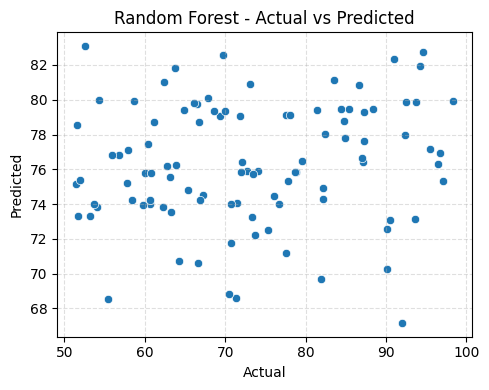

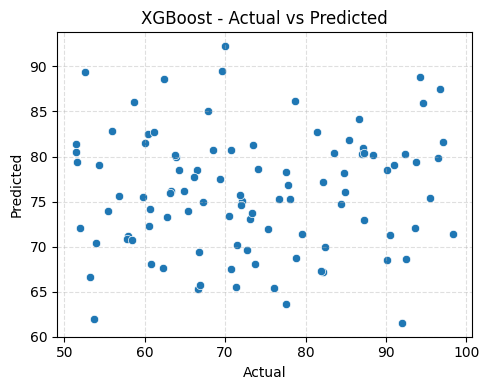

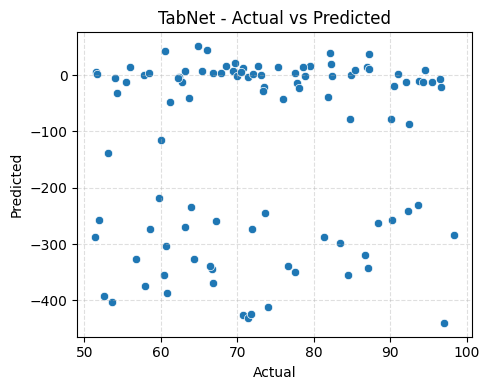

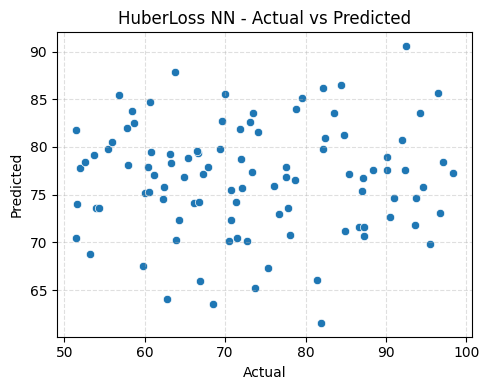

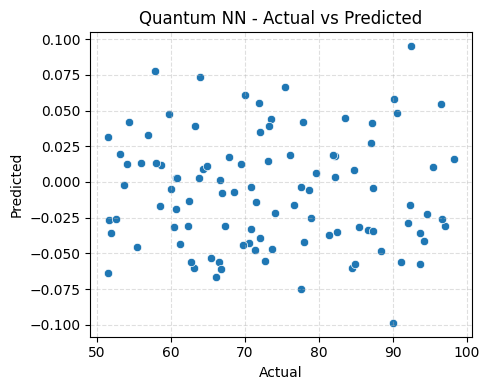

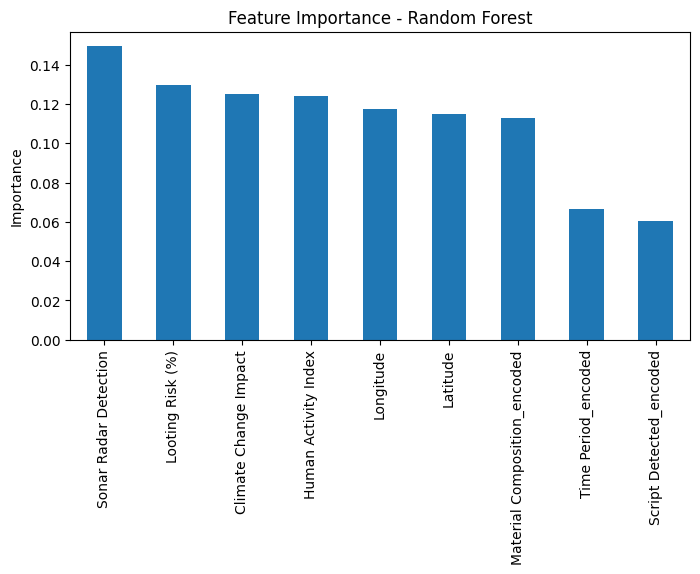


Model Performance Summary:

Random Forest
RMSE: 13.5127
MAE: 11.4291
R2: -0.0575

XGBoost
RMSE: 14.6071
MAE: 12.0879
R2: -0.2357

TabNet
RMSE: 252.9361
MAE: 197.1785
R2: -369.5099

HuberLoss NN
RMSE: 14.6440
MAE: 12.3333
R2: -0.2419

Quantum NN
RMSE: 74.4015
MAE: 73.2315
R2: -31.0583


In [47]:
# 8. Visualization
for name, preds in models.items():
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=y_test[:len(preds)], y=preds)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} - Actual vs Predicted")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Feature Importance (Random Forest)
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title="Feature Importance - Random Forest", figsize=(8,4))
plt.ylabel("Importance")
plt.show()

# Print Results
print("\nModel Performance Summary:")
for name, metrics in results.items():
    print(f"\n{name}")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")


📊 Random Forest
RMSE: 13.5127
MAE: 11.4291
R2: -0.0575

📊 XGBoost
RMSE: 14.6071
MAE: 12.0879
R2: -0.2357

📊 TabNet
RMSE: 252.9361
MAE: 197.1785
R2: -369.5099

📊 Huber NN
RMSE: 14.6440
MAE: 12.3333
R2: -0.2419

📊 Quantum NN
RMSE: 74.4015
MAE: 73.2315
R2: -31.0583


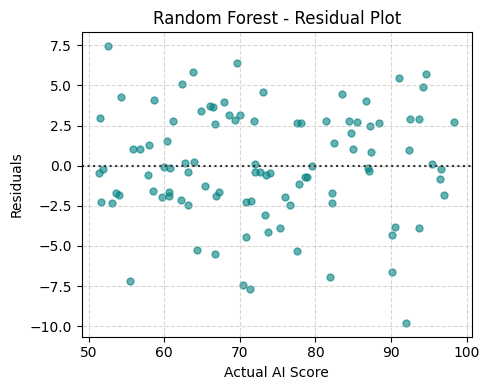

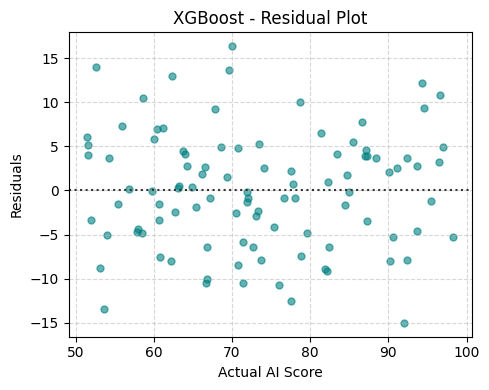

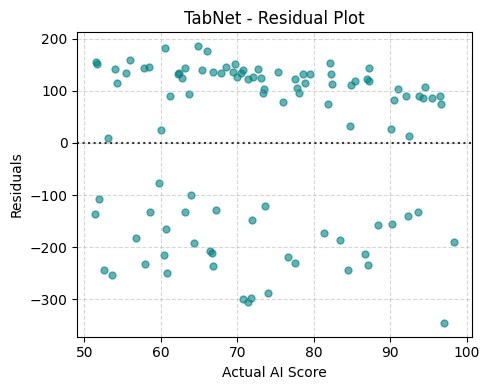

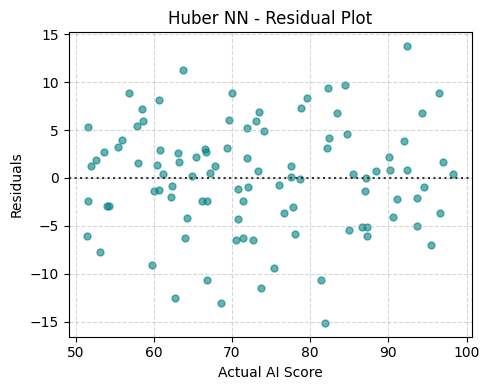

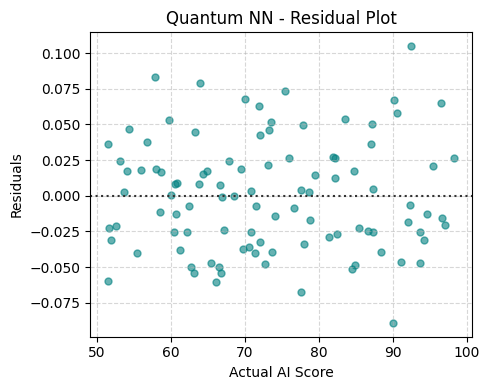

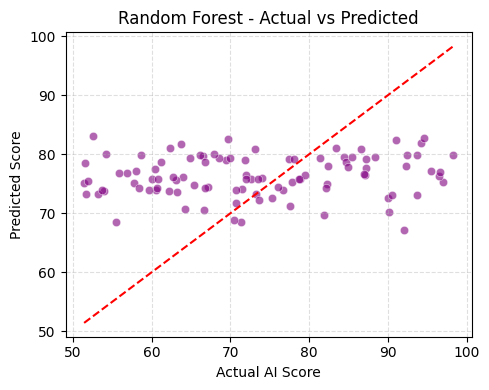

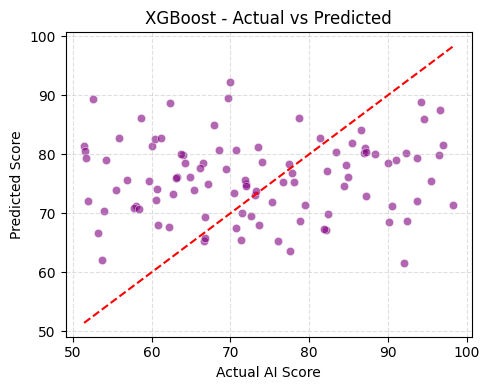

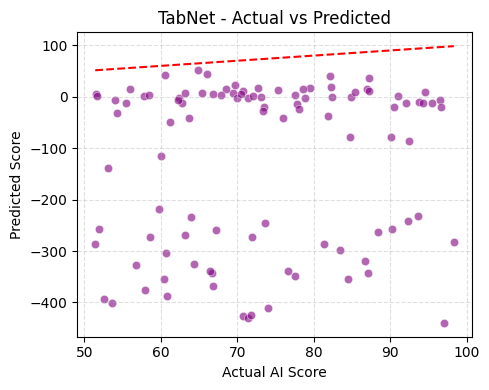

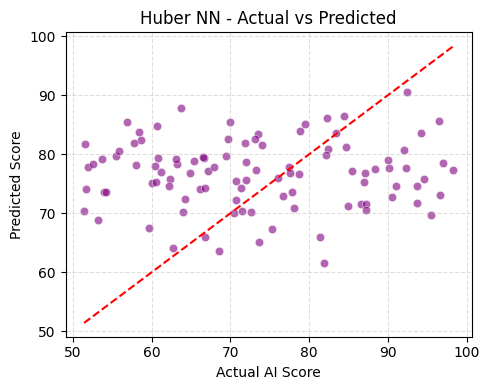

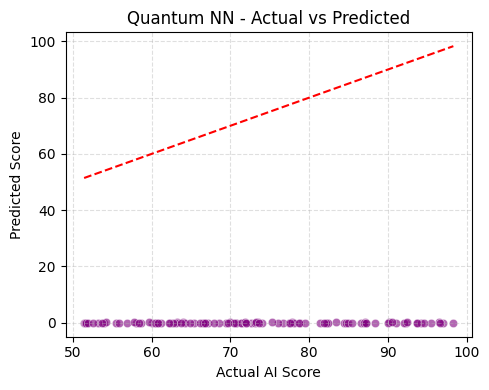

C:\Users\PC\AppData\Local\Temp\ipykernel_11704\1071364479.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


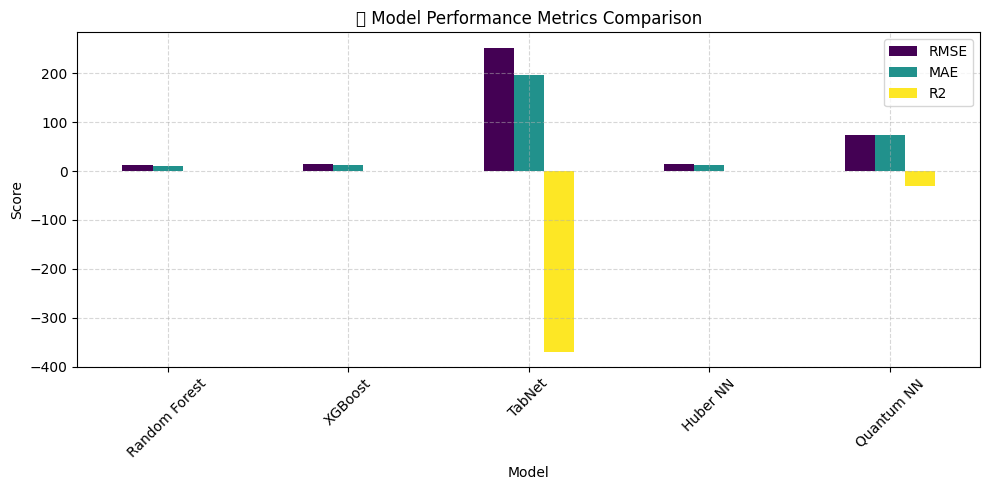

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ Evaluate function
def evaluate(y_true, y_preds):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_preds)),
        "MAE": mean_absolute_error(y_true, y_preds),
        "R2": r2_score(y_true, y_preds)
    }

# ✅ Use first 100 points for quantum to match q_preds
y_test_small = y_test[:100]

# ✅ Models
models = {
    "Random Forest": (y_test, rf_preds),
    "XGBoost": (y_test, xgb_preds),
    "TabNet": (y_test, tabnet_preds),
    "Huber NN": (y_test, h_preds),
    "Quantum NN": (y_test, q_preds)
}

# 📈 Print metrics
results_df = []
for name, (y_true, y_pred) in models.items():
    scores = evaluate(y_true, y_pred)
    print(f"\n📊 {name}")
    for k, v in scores.items():
        print(f"{k}: {v:.4f}")
    results_df.append([name, scores['RMSE'], scores['MAE'], scores['R2']])

# 📊 Residual Plots
for name, (y_true, y_pred) in models.items():
    residuals = y_true - y_pred
    plt.figure(figsize=(5, 4))
    sns.residplot(x=y_true, y=y_pred, color='teal', scatter_kws={'s': 25, 'alpha': 0.6})
    plt.title(f"{name} - Residual Plot")
    plt.xlabel("Actual AI Score")
    plt.ylabel("Residuals")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 📉 Actual vs Predicted Scatter Plots
for name, (y_true, y_pred) in models.items():
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x=y_true, y=y_pred, color='purple', alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(f"{name} - Actual vs Predicted")
    plt.xlabel("Actual AI Score")
    plt.ylabel("Predicted Score")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# 📊 Bar Chart Comparison of Metrics
metrics_df = pd.DataFrame(results_df, columns=["Model", "RMSE", "MAE", "R2"]).set_index("Model")
metrics_df.plot(kind='bar', figsize=(10, 5), colormap='viridis', rot=45)
plt.title("📊 Model Performance Metrics Comparison")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [35]:
pip install --upgrade seaborn statsmodels

Note: you may need to restart the kernel to use updated packages.



📊 Random Forest
RMSE: 13.5127
MAE: 11.4291
R2: -0.0575

📊 XGBoost
RMSE: 14.6071
MAE: 12.0879
R2: -0.2357

📊 TabNet
RMSE: 252.9361
MAE: 197.1785
R2: -369.5099

📊 Huber NN
RMSE: 14.6440
MAE: 12.3333
R2: -0.2419

📊 Quantum NN
RMSE: 74.4015
MAE: 73.2315
R2: -31.0583


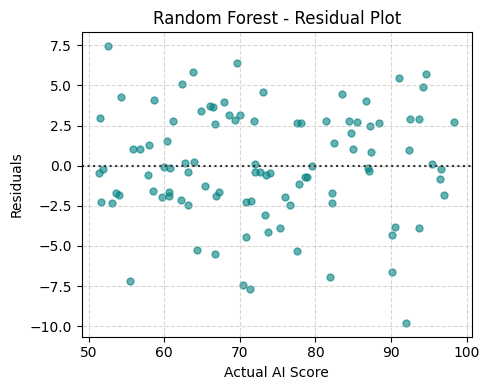

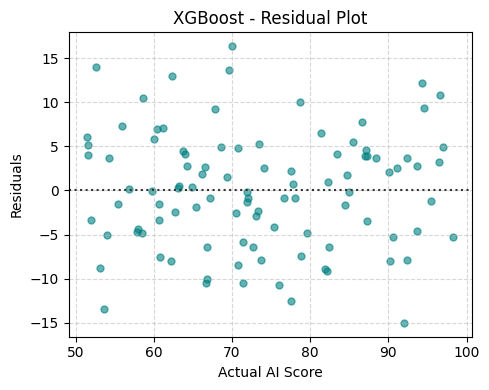

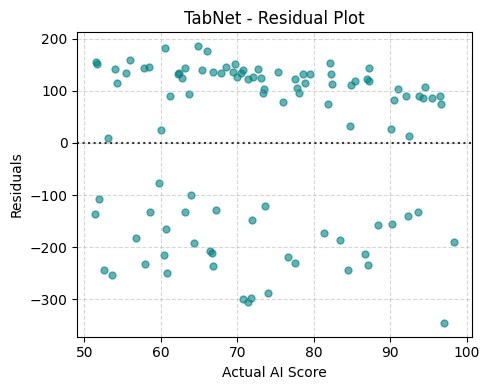

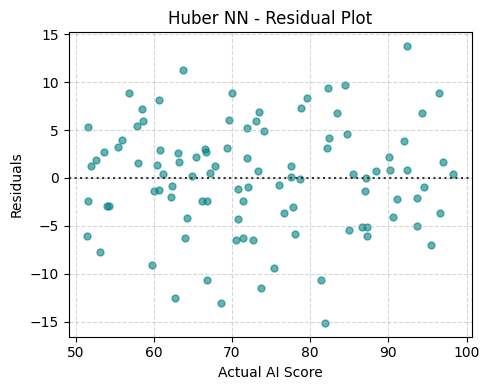

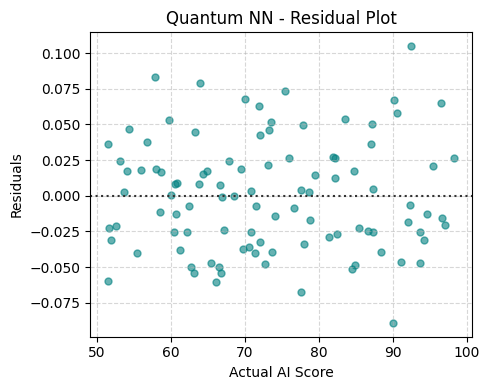

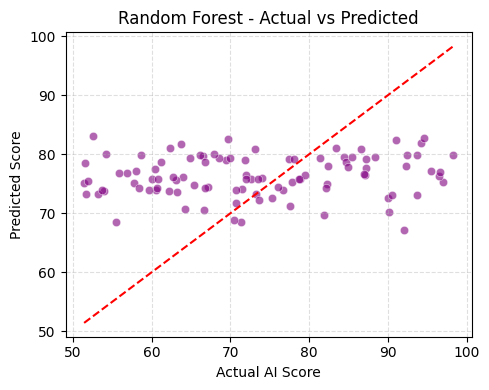

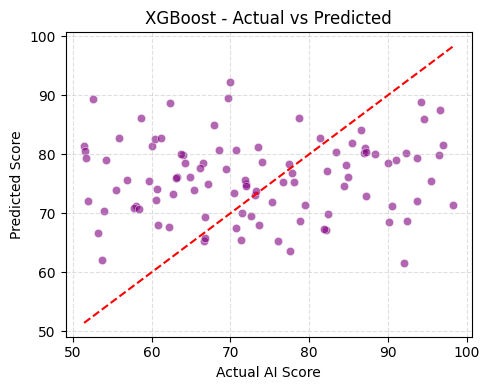

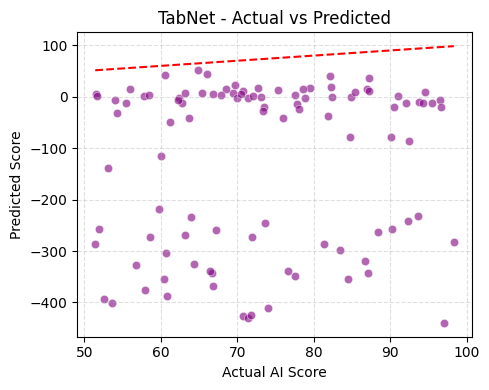

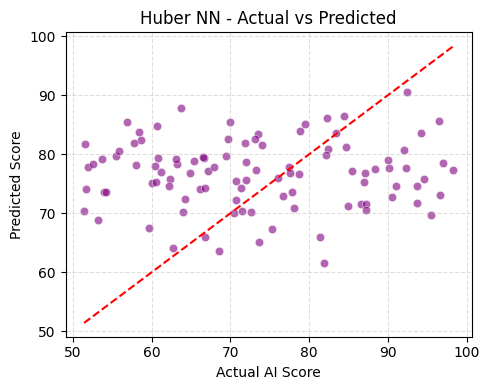

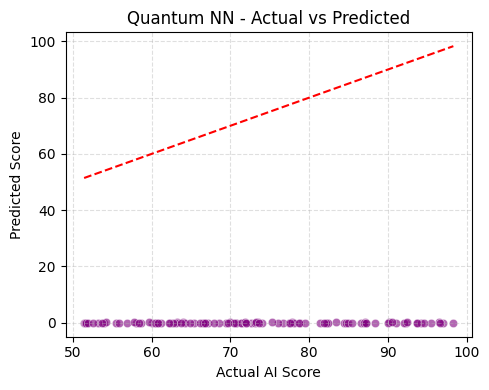

C:\Users\PC\AppData\Local\Temp\ipykernel_11704\1071364479.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


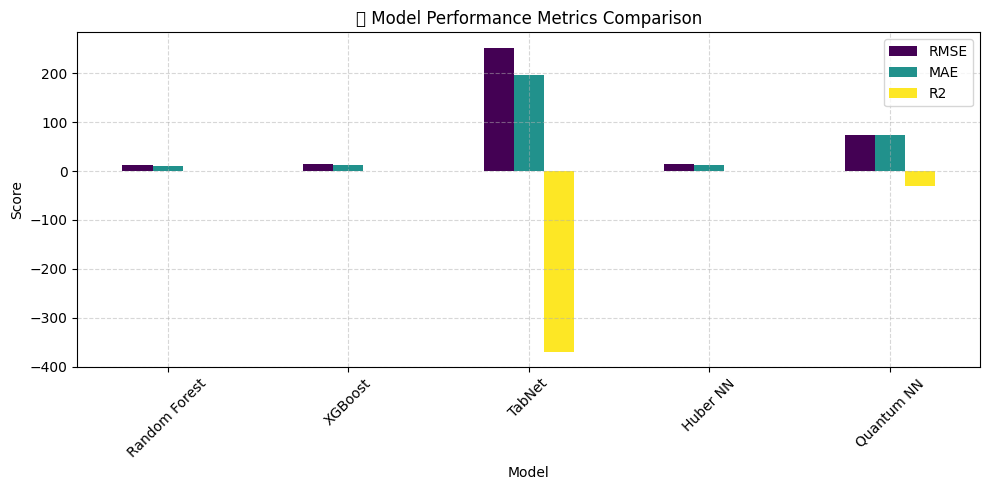

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ Evaluate function
def evaluate(y_true, y_preds):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_preds)),
        "MAE": mean_absolute_error(y_true, y_preds),
        "R2": r2_score(y_true, y_preds)
    }

# ✅ Use first 100 points for quantum to match q_preds
y_test_small = y_test[:100]

# ✅ Models
models = {
    "Random Forest": (y_test, rf_preds),
    "XGBoost": (y_test, xgb_preds),
    "TabNet": (y_test, tabnet_preds),
    "Huber NN": (y_test, h_preds),
    "Quantum NN": (y_test, q_preds)
}

# 📈 Print metrics
results_df = []
for name, (y_true, y_pred) in models.items():
    scores = evaluate(y_true, y_pred)
    print(f"\n📊 {name}")
    for k, v in scores.items():
        print(f"{k}: {v:.4f}")
    results_df.append([name, scores['RMSE'], scores['MAE'], scores['R2']])

# 📊 Residual Plots
for name, (y_true, y_pred) in models.items():
    residuals = y_true - y_pred
    plt.figure(figsize=(5, 4))
    sns.residplot(x=y_true, y=y_pred, color='teal', scatter_kws={'s': 25, 'alpha': 0.6})
    plt.title(f"{name} - Residual Plot")
    plt.xlabel("Actual AI Score")
    plt.ylabel("Residuals")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 📉 Actual vs Predicted Scatter Plots
for name, (y_true, y_pred) in models.items():
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x=y_true, y=y_pred, color='purple', alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(f"{name} - Actual vs Predicted")
    plt.xlabel("Actual AI Score")
    plt.ylabel("Predicted Score")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# 📊 Bar Chart Comparison of Metrics
metrics_df = pd.DataFrame(results_df, columns=["Model", "RMSE", "MAE", "R2"]).set_index("Model")
metrics_df.plot(kind='bar', figsize=(10, 5), colormap='viridis', rot=45)
plt.title("📊 Model Performance Metrics Comparison")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()